# **Ocean Mixing Story Group 1**

## Background 

This project aims to better understand the statistical significance of reconstructing global pCO₂ fields using ML trained on sparse data. It extends upon the analysis carried out by **Gloege et al. (2021)** *"Quantifying Errors in Observationally Based Estimates of Ocean Carbon Sink Variability."* and the method of **Bennington et al. (2022)** *"Explicit Physical Knowledge in Machine Learning for Ocean Carbon Flux Reconstruction: The pCO2-Residual Method"* by introducing a new ML method, NGBoost, which gives a probablistic prediction instead of XGBoost's point prediction. By introducting probablistic information, including standard deviations, one can understand the statistical confidence of models and how that confidence changes with the introduction of additional data. 

Oceans have absorbed 38% of all anthropogenic fossil fuel emissions over the industrial era. Yet, the scientific communitity is uncertain whether oceans will continue to absorb the same amount of carbon. Accurate estimations of air–sea CO₂ flux are critical for understanding the current and future global carbon budget, but are challenging due to the sparse and unevenly distributed nature of surface ocean pCO₂ observations. 

Probablistic predictions provide better understanding of current models based on this sparse and uneven observations versus point-based predictions. By better understanding and confidence in pCO2 reconstructions, scientists can more accurately convey recommendations based on the models, such as more accurately answer questions related to carbon budgets and other scientific and socio-economic questions related to climate change. Additionally, this research can inform scientific funding, helping to answer whether more real-world pCO₂ observations are needed for more accurate models.   

## Goals 

This analysis has two goals:
1. Determine the **statistical confidence and variability** of the pCO₂ reconstructions across the globe
2. Investigate how **adding more observations** affects statistical confidence and variability

Results from this investigation will help answer where there is more variation in the data and likewise where there is greater confidence in the pCO₂ reconstructions.

Furthermore, this analysis will help answer the degree to which adding data will improve the confidence of reconstruction models generally. Going a step deeper, this investigation can give insight into whether it is more important to add more observations in locations historically sampled, or in locations not in the database. Relatedly, this research can inform which areas of the globe are most important to direct funding towards sampling, or to focus other statistical technique to improve model confidence. 

## ML model 

Both NGBoost and XGBoost are gradient boosting algorithms. NGBoost is a gradient boosting algorithm that focuses on probabilistic predictions and uncertainty estimation, while XGBoost is a general-purpose gradient boosting algorithm known for its accuracy and efficiency.

The NGBoost method is more resource intensive than XGBoost. As such, this analysis focuses on one ESM model and 3 members.

## Adding Observations

In section 2, there is an investigation of how adding data to the model affects statistical confidence and variability. In particular, we investigate adding data across 2 dimensions:

1. Adding more observations at locations that have historically been sampled. 
2. Adding new locations, not previously sampled for pCO2 concentrations.

In both methods, we investigate increasing sampling by 14%, 30%, and 50% compared to current observations. In 1., this research adds more observations to locations that have historically been sampled. In 2., this research focuses on adding new locations in 3 undersampled Ocean Basins: Southern Ocean, Indian Ocean, and Pacific Ocean between Australia and South America. (Arctic areas were not added given the lack of coverage in ESMs).   

## Key Findings

TO BE FILLED OUT

## Structure:

0. Setup
1. Understanding Surface pCO₂ Sampling
2. Training NGBoost Model
3. Stastistical Analysis of pCO₂ Reconstructions
4. Testing Additional Members
5. Conclusion

In [1]:
your_username = 'azamkhan99'  # username of the person running the code. Reviewers should also change this to their own username.

#To allow the reviewer to access the saved files, provide notebook owner's username here:  
owner_username = 'azamkhan99'  # Reviewer should not change this name

# 0. Setup Workspace and Import Packages


In [2]:
%%capture
!pip install tensorflow
!pip install keras
!pip install --upgrade ngboost

In [3]:
%%capture
### standard imports ###
import numpy as np
import pandas as pd
import xarray as xr
import gcsfs
### Python file with supporting functions ###
# standard imports
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sys
# Redirect all low-level stderr output
sys.stderr = open(os.devnull, 'w')

import datetime
from collections import defaultdict
import random
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth',100)
import csv
import cmocean as cm

# machine learning libraries
import xgboost as xgb     
from xgboost import XGBRegressor

from ngboost import NGBRegressor
from ngboost.distns import Normal
from ngboost.scores import LogScore

# Change to the parent directory of the current working directory. (Run only once—otherwise it will keep moving up the directory tree)
os.chdir(os.path.dirname(os.getcwd()))
print("Current working directory:", os.getcwd())

# Python file with supporting functions
import lib.residual_utils as supporting_functions
from lib.visualization import *
from lib.bias_figure2 import concat_datasets, XarrayEvaluator
from lib.corr_figure3 import eval_spatial
import lib.functions as func
import lib.group1_utils as g1u

plot_style = "seaborn-v0_8-talk"

In [4]:
from lib.config import (
    SOCAT_PATH,
    PATH_SEEDS,
    GRID_SEARCH_APPROACH,
    MLINPUTS_PATH,
    ENSEMBLE_DIR,
    FEATURES_SEL,
    TARGET_SEL,
)

In [5]:
### Setting the date range to unify the date type ###

# Define date range
date_range_start = '2004-01-01T00:00:00.000000000'
date_range_end = '2023-12-31T00:00:00.000000000'

# create date vector, adds 14 days to start & end
dates = pd.date_range(start=date_range_start, 
                      end=date_range_end,freq='MS')


init_date = str(dates[0].year) + format(dates[0].month,'02d')
fin_date = str(dates[-1].year) + format(dates[-1].month,'02d')

# 1. Surface ocean pCO2: A sparse data challenge

Analyze stastical metrics of real-world & theoretical sampling of pCO₂

## 1.1
### 🔹 Original Mask

- **`socat_mask_data`**  
  The baseline SOCAT sampling mask, showing where and when surface ocean pCO₂ has been measured.

---

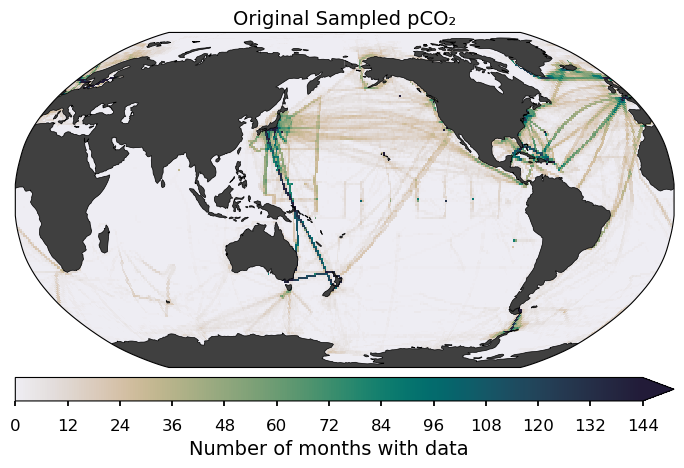

In [7]:
socat_mask_data = xr.open_zarr(SOCAT_PATH).sel(time=slice(str(dates[0]),str(dates[-1])))
non_zero_counts = (socat_mask_data.socat_mask != 0).sum(dim="time")

plot_mask(non_zero_counts, "Original Sampled pCO₂")

Here, we visualize all SOCAT data for the period selected for this analysis (default is 2004-2023) at each 1 degree X 1 degree location (100x100km at the equator). 

Data is sparse, with only around 2% of the globe sampled. The majority of the sampling is in the northern hemisphere

## 1.2
## Adding More Locations

This notebook investigates how different sampling strategies affect the statistical confidence of pCO₂ reconstructions.  

In both methods, we investigate samples increases of 14%, 30%, and 50%. "Augmenting existing locations" looks at adding more data to locations that have already been sampled historically, while "adding new locations" only looks to add data in places that have not historically been sampled. 

Given the methodology, both methods tend to add data outside of typical shipping routes, especially in the Southern Hemisphere. The "adding new locations" is more concentrated in the additions, while the new data in "augmenting existing" is more dispersed. 

---

### 1.2.1
### 🔸 Augmenting Existing Sampled Locations

These variants **increase the number of samples at already-sampled locations** without changing the spatial coverage.

- **`socat_mean_glob`**  
  Boosts under-sampled locations (below global mean) to the global mean number of sampling months (14% increase).

- **`socat_30p_glob`**  
  Ensures all existing sampled grid cells have at least 7 months of data (≈30% increase).

- **`socat_50p_glob`**  
  Ensures all existing sampled grid cells have at least 10 months of data (≈50% increase).

---

In [8]:
#Add more sampling to areas with low historical sampling
mean_val_glob_loc, socat_mean_glob, thirtyp_val_glob, socat_30p_glob, fiftyp_val_glob, socat_50p_glob = func.add_to_existing(non_zero_counts, socat_mask_data)

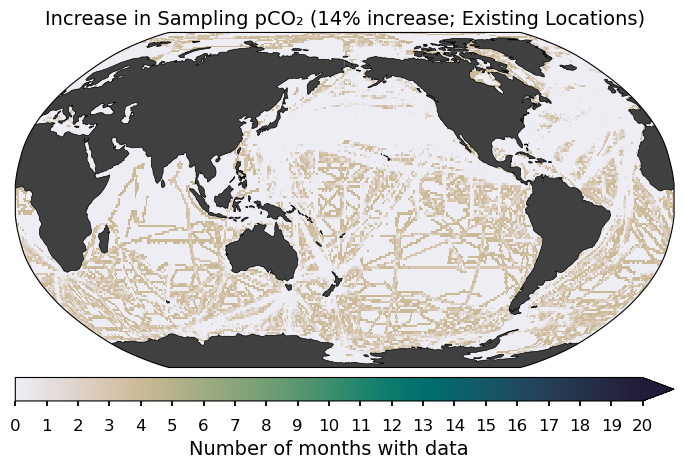

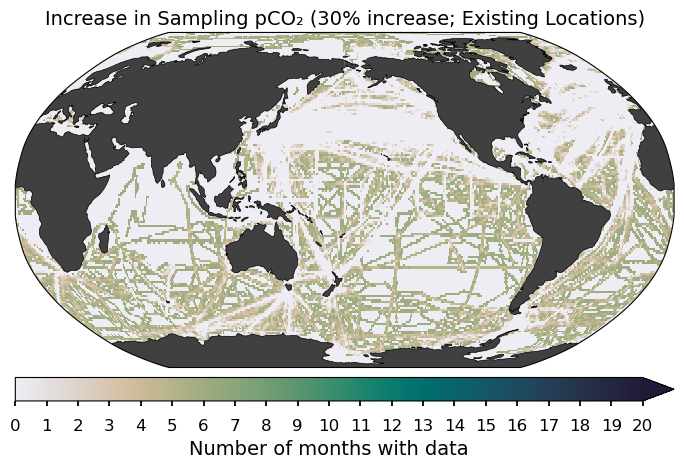

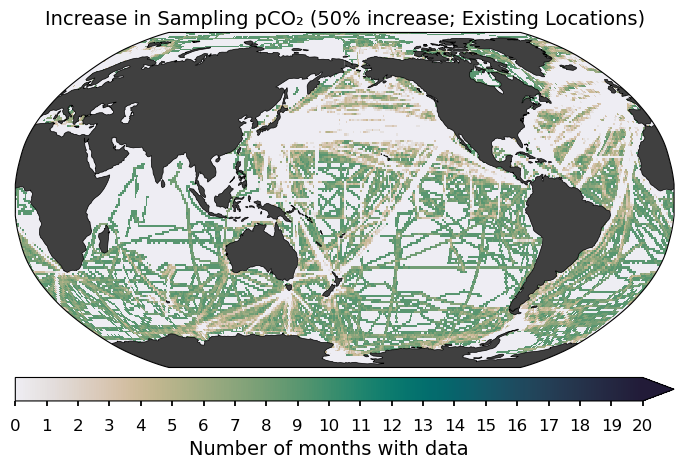

In [9]:
diff_mean = mean_val_glob_loc - non_zero_counts
diff_30p  = thirtyp_val_glob  - non_zero_counts
diff_50p  = fiftyp_val_glob   - non_zero_counts

#visualize increase in sampling
plot_mask(diff_mean, "Increase in Sampling pCO₂ (14% increase; Existing Locations)",[0, 20, 1])
plot_mask(diff_30p, "Increase in Sampling pCO₂ (30% increase; Existing Locations)",[0, 20, 1])
plot_mask(diff_50p, "Increase in Sampling pCO₂ (50% increase; Existing Locations)",[0, 20, 1])

### 1.2.2
### 🔸 Adding New Sample Locations

These variants **expand the spatial footprint** by adding sampling at new locations in undersampled ocean regions.

- **`addmeanp_socat`**  
  Adds ~14% new grid points in each of the three undersampled basins, sampled at the global mean frequency.

- **`add30p_socat`**  
  Adds 100 new grid points per basin, each with moderate sampling (~7 months).

- **`add50p_socat`**  
  Adds 200 new grid points per basin, each with higher sampling (~10 months).

---

<table style="border-collapse: collapse; width: 100%;">
  <tr>
    <th style="border: 1px solid black;">Region</th>
    <th style="border: 1px solid black;">Latitude Range</th>
    <th style="border: 1px solid black;">Longitude Range</th>
  </tr>
  <tr>
    <td style="border: 1px solid black;">Pacific 1</td>
    <td style="border: 1px solid black;">-46 to -36</td>
    <td style="border: 1px solid black;">-97 to -87</td>
  </tr>
  <tr>
    <td style="border: 1px solid black;">Pacific 2</td>
    <td style="border: 1px solid black;">-45 to -35</td>
    <td style="border: 1px solid black;">-130 to -110</td>
  </tr>
  <tr>
    <td style="border: 1px solid black;">Pacific 3</td>
    <td style="border: 1px solid black;">-32 to -27</td>
    <td style="border: 1px solid black;">-141 to -121</td>
  </tr>
  <tr>
    <td style="border: 1px solid black;">Southern Ocean</td>
    <td style="border: 1px solid black;">-76 to -67</td>
    <td style="border: 1px solid black;">-60 to -40</td>
  </tr>
  <tr>
    <td style="border: 1px solid black;">Indian Ocean 1</td>
    <td style="border: 1px solid black;">-11 to 9</td>
    <td style="border: 1px solid black;">75 to 85</td>
  </tr>
  <tr>
    <td style="border: 1px solid black;">Indian Ocean 2</td>
    <td style="border: 1px solid black;">-30 to -25</td>
    <td style="border: 1px solid black;">70 to 90</td>
  </tr>
</table>

In [10]:
addmeanp_oceans, addmeanp_socat, add30p_oceans, add30p_socat,\
    add50p_oceans, add50p_socat = func.add_new(non_zero_counts, socat_mask_data)

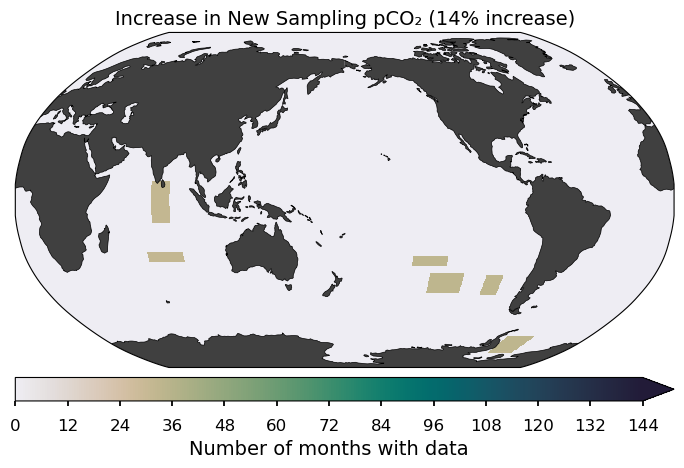

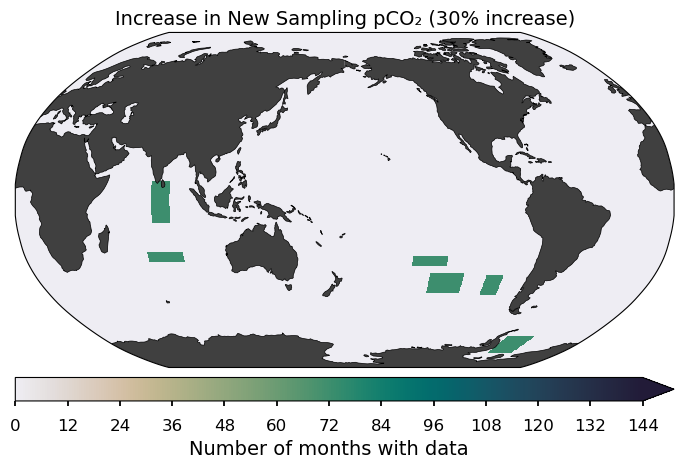

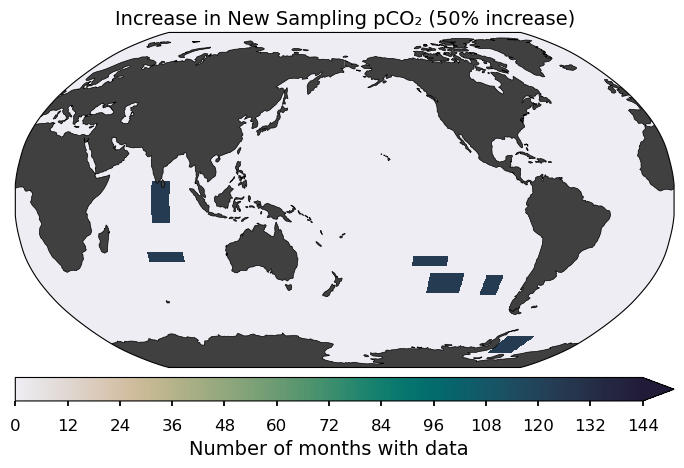

In [11]:
diff_mean_n = addmeanp_oceans - non_zero_counts
diff_30p_n  = add30p_oceans  - non_zero_counts
diff_50p_n  = add50p_oceans   - non_zero_counts

#visualize increase in sampling
plot_mask(diff_mean_n, "Increase in New Sampling pCO₂ (14% increase)")
plot_mask(diff_30p_n, "Increase in New Sampling pCO₂ (30% increase)")
plot_mask(diff_50p_n, "Increase in New Sampling pCO₂ (50% increase)")

In [12]:
mask_data_dict = {
    "baseline": socat_mask_data,
    "densify_mean_pattern": socat_mean_glob,
    "densify_30p": socat_30p_glob,
    "densify_50p": socat_50p_glob,
    "expand_14p": addmeanp_socat,
    "expand_30p": add30p_socat,
    "expand_50p": add50p_socat,
}

In [13]:
non_zero_dict = {
    "baseline" : non_zero_counts,
    "densify_mean_pattern": mean_val_glob_loc,
    "densify_30p": thirtyp_val_glob,
    "densify_50p": fiftyp_val_glob,
    "expand_14p": addmeanp_oceans,
    "expand_30p": add30p_oceans,
    "expand_50p": add50p_oceans 
}

# 2. NGBoost Model Training

### 2.1 Training with NGBoost on observations

In [14]:
### train-validate-test split proportions ###

select_dates = []
test_dates = []

for i in range(0, len(dates)):
    if i % 5 != 0:
        select_dates.append(dates[i])  ### 80% train days set ###
    if i % 5 == 0:
        test_dates.append(dates[i])  ### 20% test days set ###

### Then, the month numbers above are converted back to their respective datetime objects.

year_mon = []

for i in range(0, len(select_dates)):
    tmp = select_dates[i]
    year_mon.append(f"{tmp.year}-{tmp.month}")

test_year_mon = []

for i in range(0, len(test_dates)):
    tmp = test_dates[i]
    test_year_mon.append(f"{tmp.year}-{tmp.month}")


In [15]:
features_sel = FEATURES_SEL
target_sel = TARGET_SEL

path_seeds = PATH_SEEDS
grid_search_approach = GRID_SEARCH_APPROACH
MLinputs_path = MLINPUTS_PATH
ensemble_dir = ENSEMBLE_DIR

output_dir = f"gs://leap-persistent/{your_username}/{owner_username}/pco2_residual/{grid_search_approach}/post02_xgb"  # where to save machine learning results
metrics_output_dir = f"{output_dir}/metrics"  # where to save performance metrics
test_perform_fname = f"{metrics_output_dir}/ngb_test_performance_{init_date}-{fin_date}.csv"  # path for test performance metrics

In [16]:
ngb_params = {
    "n_estimators": 500,  # Number of boosting rounds
    "learning_rate": 0.05,  # Learning rate
    "natural_gradient": True,  # Use natural gradient
    "minibatch_frac": 0.8,  # Proportion of data used per iteration
    "col_sample": 0.8,  # Feature proportion per tree
    "verbose": True,  # Disable training output
    "Score": LogScore,  # Loss function
    "early_stopping_rounds": 25,  # Early stopping rounds
}


In [17]:
selected_mems_dict = {
    "ACCESS-ESM1-5": ["member_r10i1p1f1", "member_r5i1p1f1", "member_r2i1p1f1"],
}

In [ ]:
# Call the function
g1u.run_ngboost_with_masks(
    mask_data_dict=mask_data_dict,
    selected_mems_dict=selected_mems_dict,
    features_sel=features_sel,
    target_sel=target_sel,
    year_mon=year_mon,
    test_year_mon=test_year_mon,
    path_seeds=path_seeds,
    MLinputs_path=MLinputs_path,
    dates=dates,
    init_date=init_date,
    fin_date=fin_date,
    output_dir=output_dir,
    params=ngb_params,  # NGBoost parameters
    runthiscell=-1,  # -1 = first member of first ensemble only (use 1 to run all)
#    your_username=your_username,  # username of the person running the code. Reviewer should also change this to their own username.
)


### 2.2 Reconstruction pCO₂ using ESMs

In [19]:
seed_loc_dict = defaultdict(dict)
for ens, mem_list in selected_mems_dict.items():
    sub_dictt = {mem: no for no, mem in enumerate(mem_list)}
    seed_loc_dict[ens] = sub_dictt

In [24]:
g1u.run_reconstruction_with_masks(
    mask_data_dict=mask_data_dict,
    selected_mems_dict=selected_mems_dict,
    features_sel=features_sel,
    target_sel=target_sel,
    year_mon=year_mon,
    test_year_mon=test_year_mon,
    seed_loc_dict=seed_loc_dict,
    MLinputs_path=MLinputs_path,
    init_date=init_date,
    fin_date=fin_date,
    output_dir=output_dir,
    dates=dates,
    runthiscell=-1,  # -1 = first member of first ensemble only (use 1 to run all)
#    username=your_username,  # username of the person running the code. Reviewer should also change this to their own username.
)


Reviewing process: Running reconstruction only for the first member of the first ESM. 
Running reconstruction only for the first mask.

Running reconstruction for mask: baseline

ACCESS-ESM1-5 member_r10i1p1f1
Model loaded from GCS at: gs://leap-persistent/azamkhan99/azamkhan99/pco2_residual/nmse/post02_xgb/models/baseline_model_pCO2_2D_ACCESS-ESM1-5_r10i1p1f1_mon_1x1_200401_202312.p
count    1.555200e+07
mean     1.846200e-02
std      1.346148e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: socat_mask, dtype: float64
Applied new SOCAT mask
count    1.555200e+07
mean     1.846200e-02
std      1.346148e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: socat_mask, dtype: float64
Total selected locations for training (baseline): 223875
Total unseen locations (baseline): 7859225
unseen performance metrics for baseline: {'mse': 182.8361949103104, 'mae

### 2.3 Inverse Residual Transformation

In [ ]:
runthiscell = 0  # 0 will turn off, 1 will turn on, -1 will only run first member

if runthiscell:
    # Use the first masks if only testing with the first ensemble member
    if runthiscell == -1:
        first_mask = list(mask_data_dict.keys())[0]
        run_selected_mask_data_dict = {first_mask: mask_data_dict[first_mask]}
    else:
        run_selected_mask_data_dict = mask_data_dict

    for mask_name, mask_data in run_selected_mask_data_dict.items():
        print(f"Processing mask: {mask_name}")

        calc_recon_pco2(
            regridded_members_dir=ensemble_dir,
            pco2_recon_dir=f"{output_dir}/reconstructions/{mask_name}",
            selected_mems_dict=selected_mems_dict,
            mask_name=mask_name,
            init_date=init_date,
            fin_date=fin_date,
            owner_name=your_username if runthiscell == -1 else None,
        )

        print(f"Finished processing mask: {mask_name}")

In [ ]:
from google.cloud import storage

if runthiscell != -1:
    client = storage.Client()
    bucket = client.bucket("leap-persistent")

    for mask_name, mask_data in mask_data_dict.items():
        print(f"Processing mask: {mask_name}")

        # Define the prefix for the blobs you want to make public
        prefix = f"{your_username}/{your_username}/pco2_residual/nmse/post02_xgb/reconstructions/{mask_name}/"
        blobs = bucket.list_blobs(prefix=prefix)

        seen_dirs = (
            set()
        )
        # Track top-level directories (immediate subdirectories of `reconstructions`)
        for blob in blobs:
            # Extract the relative path after `reconstructions/`
            relative_path = blob.name[len(prefix) :]
            top_level_dir = relative_path.split("/")[0]
            # print(relative_path)


            # Get first component
            try:
                # Make the file public
                blob.make_public()

                # Only print if it's a new top-level directory
                if top_level_dir not in seen_dirs:
                    seen_dirs.add(top_level_dir)
                    print(f"Made public: {top_level_dir}")
                    # print(seen_dirs)
            except Exception as e:
                print(f"Failed to make public: {blob.name}")
                print(e)

Processing mask: baseline
Made public: ACCESS-ESM1-5
Processing mask: densify_mean_pattern
Made public: ACCESS-ESM1-5
Processing mask: densify_30p
Made public: ACCESS-ESM1-5
Processing mask: densify_50p
Made public: ACCESS-ESM1-5
Processing mask: expand_14p
Made public: ACCESS-ESM1-5
Processing mask: expand_30p
Made public: ACCESS-ESM1-5
Processing mask: expand_50p
Made public: ACCESS-ESM1-5


# 3 Analyzing Model Reconstruction

## 3.1 Reconstruction of Baseline

### THINK MAKES SENSE TO SHOW 1. AVG pCO2; 2. AVG STD; 3. P-VAL

## 3.2 Comparison of Baseline vs models trained on more data

### 3.2.1 Analyze data added to locations historically sampled

### THINK MAKES SENSE TO SHOW 3 GRAPHS FOR EACH SAMPLE: 1.CHANGE IN AVG pCO2; 2. CHANGE IN STD; 3. CHANGE P.VAL

### THINK CAN DROP THE DENSIFY_MEAN_PATTERN GRAPHS

### 3.2.2 Analyze data added to new locations not historically sampled

### Match 3.2.1. SHOW 3 GRAPHS FOR EACH SAMPLE: 1.CHANGE IN AVG pCO2; 2. CHANGE IN STD; 3. CHANGE P.VAL

### DROP THE DENSIFY_MEAN_PATTERN GRAPHS

# 4. Reproducibility - checking additional members

# 5. Seasonality (tbd if needed)

# 6. Conclusions